In [4]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import fix_yahoo_finance as yf
import seaborn as sns
style.use("ggplot")

%matplotlib inline

# 1. Plot correlation heatmaps from Yahoo Finance's tickers

# 1.1 Call Yahoo Finance API

In [4]:
def get_yahoo_data(symbol_list, start_str, end_str):
    """
    Documentation: start/end_str is of the format of, e.g. "2017-09-15"
    """
    import_ = yf.download(symbol_list, start = start_str, end = end_str)
    df = import_.to_frame().unstack()
    return df

In [6]:
test_list = get_yahoo_data(['ABB', 'CMCSA', 'CS', 'HAL'], '2010-01-01', '2019-03-21')

[*********************100%***********************]  4 of 4 downloaded


AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [7]:
import_ = yf.download(['ABB', 'CMCSA', 'CS', 'HAL'], start = '2010-01-01', end = '2019-03-21')

[*********************100%***********************]  4 of 4 downloaded


In [29]:
import_.head(3)

Open                                    High         \
                  ABB  CMCSA         CS        HAL        ABB  CMCSA   
Date                                                                   
2009-12-31  19.290001  8.530  48.408203  30.309999  19.420000  8.575   
2010-01-04  19.590000  8.375  49.902344  30.719999  19.709999  8.565   
2010-01-05  19.600000  8.465  51.250000  31.280001  19.799999  8.490   

                                    Low           ...         Close         \
                   CS    HAL        ABB  CMCSA    ...            CS    HAL   
Date                                              ...                        
2009-12-31  48.730469  30.52  19.100000  8.430    ...     48.007813  30.09   
2010-01-04  51.035156  31.34  19.510000  8.375    ...     50.771484  31.25   
2010-01-05  51.318359  31.83  19.540001  8.275    ...     51.191406  31.65   

            Adj Close                                   Volume            \
                  ABB     CMCSA         CS        HAL      ABB     CMCSA   
Date                                                                       
2009-12-31  14.166453  6.216340  34.214092  26.293697  1518000  16245600   
2010-01-04  14.566971  6.327832  36.183693  27.307341  1847200  27146800   
2010-01-05  14.663393  6.242068  36.482964  27.656870  2881700  35493000   

                              
                CS       HAL  
Date                          
2009-12-31  203900   7678700  
2010-01-04  734200  11571600  
2010-01-05  447700  18989700  

[3 rows x 24 columns]

# 1.2 Plot Correlation Heatmaps

## 1.2.1 Process data

In [18]:
stacked = import_.stack().reset_index()

In [20]:
stacked.columns

Index(['Date', 'level_1', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')

In [23]:
stacked.columns = ['date', 'tickers', 'close', 'close2', 'high', 'low', 'open','volume']
stacked_ = stacked[['date', 'tickers', 'open', 'high', 'low', 'close', 'volume']]
stacked_open = stacked_[['date', 'tickers', 'open']]

In [33]:
stacked_open_pvt = pd.pivot_table(stacked_open, values = 'open', index = 'date', columns = 'tickers')
stacked_open_pvt_pctchg = stacked_open_pvt.pct_change()

## 1.2.2 Generate correlation matrix and plot heatmaps

In [37]:
stacked_open_pvt_pctchg.corr()

tickers,ABB,CMCSA,CS,HAL
tickers,,,,
ABB,1.000000,0.416404,0.609883,0.482867
CMCSA,0.416404,1.000000,0.385370,0.354558
CS,0.609883,0.385370,1.000000,0.414827
HAL,0.482867,0.354558,0.414827,1.000000


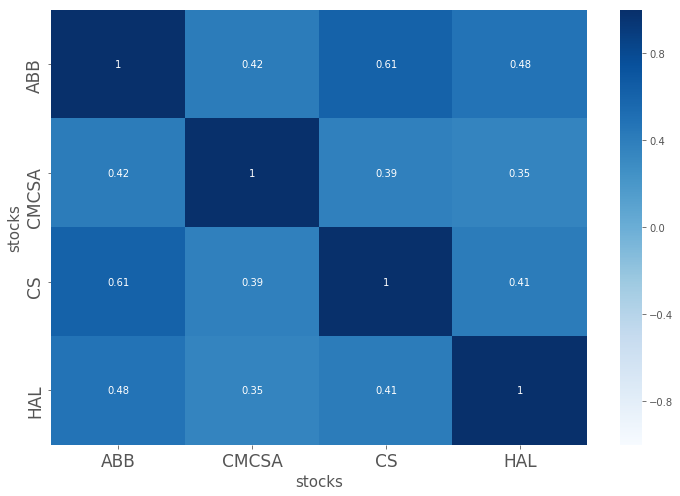

In [44]:
# 最后一步：plot heatmap:
import seaborn as sns

fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(stacked_open_pvt_pctchg.corr()[abs(stacked_open_pvt_pctchg.corr())>-2], ax = ax, cmap = 'Blues', vmax = 1.0, vmin = -1.0, annot=True)
plt.xlabel('stocks', fontsize = 15)
plt.ylabel('stocks', fontsize = 15)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17);

## 1.3 Create an AIO function

In [8]:
def corr_heatmaps_yf(symbol_list, price_col, start_str, end_str, corr_thresh):
    """
    Documentation: 
    1. start/end_str is of the format of, e.g. "2017-09-15"
    2. corr_thresh ranges from -1 to 1
    
    """
    df = yf.download(symbol_list, start = start_str, end = end_str)
    stacked = df.stack().reset_index()
    stacked.columns = ['date', 'tickers', 'close', 'close2', 'high', 'low', 'open','volume']
    stacked_ = stacked[['date', 'tickers', 'open', 'high', 'low', 'close', 'volume']]
    stacked_col = stacked_[['date', 'tickers', price_col]]
    stacked_col_pvt = pd.pivot_table(stacked_col, values = price_col, index = 'date', columns = 'tickers')
    stacked_col_pvt_pctchg = stacked_col_pvt.pct_change()
    fig, ax = plt.subplots(figsize = (12, 8))
    sns.heatmap(stacked_col_pvt_pctchg.corr()[(stacked_col_pvt_pctchg.corr()>corr_thresh)|(stacked_col_pvt_pctchg.corr()<-corr_thresh)], ax = ax, cmap = 'Blues', vmax = 1.0, vmin = -1.0, annot=True)
    plt.xlabel('stocks', fontsize = 15)
    plt.ylabel('stocks', fontsize = 15)
    plt.xticks(fontsize = 17)
    plt.yticks(fontsize = 17)
    return stacked_col_pvt_pctchg

[*********************100%***********************]  6 of 6 downloaded


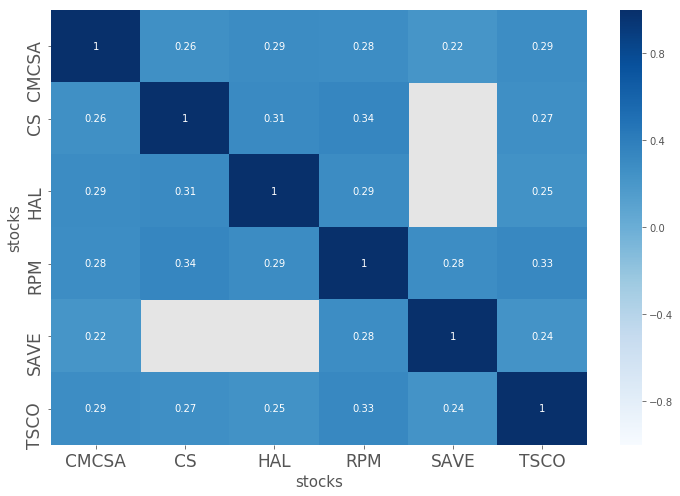

In [9]:
stacked_col_pvt_pctchg = corr_heatmaps_yf(['RPM', 'CMCSA', 'CS', 'HAL', 'TSCO', 'SAVE'], 'open', '2015-01-01', '2019-03-21', 0.2)

In [11]:
stacked_col_pvt_pctchg.corr()

tickers,CMCSA,CS,HAL,RPM,SAVE,TSCO
tickers,,,,,,
CMCSA,1.000000,0.261637,0.294014,0.284949,0.221269,0.287672
CS,0.261637,1.000000,0.310717,0.338392,0.193513,0.267483
HAL,0.294014,0.310717,1.000000,0.293123,0.185086,0.247997
RPM,0.284949,0.338392,0.293123,1.000000,0.283856,0.326049
SAVE,0.221269,0.193513,0.185086,0.283856,1.000000,0.241267
TSCO,0.287672,0.267483,0.247997,0.326049,0.241267,1.000000
